In [29]:
!wget https://archive.ics.uci.edu/static/public/275/bike+sharing+dataset.zip


--2024-08-27 17:28:05--  https://archive.ics.uci.edu/static/public/275/bike+sharing+dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bike+sharing+dataset.zip.2’

bike+sharing+datase     [  <=>               ] 273.43K  1.13MB/s    in 0.2s    

2024-08-27 17:28:06 (1.13 MB/s) - ‘bike+sharing+dataset.zip.2’ saved [279992]



In [30]:
!unzip bike+sharing+dataset.zip

Archive:  bike+sharing+dataset.zip
replace Readme.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Readme.txt              
replace day.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: day.csv                 
replace hour.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: hour.csv                


In [3]:
!pip install category_encoders


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 819.9 kB/s eta 0:00:00


In [31]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler # TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from category_encoders import TargetEncoder

df = pd.read_csv('hour.csv')


In [32]:
df['day_night'] = df['hr'].apply(lambda x: 'day' if 6 <= x <= 18 else 'night')
df.drop(['instant', 'casual', 'registered'], axis=1, inplace=True)


In [33]:
df['dteday'] = pd.to_datetime(df.dteday)
df['season'] = df.season.astype('category')
df['holiday'] = df.holiday.astype('category')
df['weekday'] = df.weekday.astype('category')
df['weathersit'] = df.weathersit.astype('category')
df['workingday'] = df.workingday.astype('category')
df['mnth'] = df.mnth.astype('category')
df['hr_temp_interaction'] = df['hr'] * df['temp']
df['hr_hum_interaction'] = df['hr'] * df['hum']
df['yr'] = df.yr.astype('category')
df['hr'] = df.hr.astype('category')
df.drop(columns=['dteday'], inplace=True)
X = df.drop(columns=['cnt', 'holiday']) # Features
y = df['cnt'] # Target

numerical_features = ['temp', 'hum','windspeed','hr_temp_interaction','hr_hum_interaction']
numerical_pipeline = Pipeline([
('imputer', SimpleImputer(strategy='mean')),
('scaler', MinMaxScaler())
])
X[numerical_features] = numerical_pipeline.fit_transform(X[numerical_features])


In [15]:
numerical_pipeline

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler())])

In [34]:
categorical_features = ['season', 'weathersit', 'day_night']
categorical_pipeline = Pipeline([
('imputer', SimpleImputer(strategy='most_frequent')),
('target_encoder', TargetEncoder())
])

X_encoded = categorical_pipeline.fit_transform(X[categorical_features],y)
X_encoded.columns = categorical_features
X = pd.concat([X.drop(columns=categorical_features), X_encoded], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [17]:
categorical_pipeline

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('target_encoder', TargetEncoder(cols=[0, 1, 2]))])

In [20]:
#Running this cell will use Linear Regressor from sklearn library

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

'\nplt.title(\'Feature Importances from Linear Regression\')\nplt.xlabel(\'Features\')\nplt.ylabel(\'Coefficient Value\')\nplt.show()\n\n\nfeat_importances = pd.DataFrame(lr.feature_importances_, index=X_train.columns,\ncolumns=["Importance"])\nfeat_importances.sort_values(by=\'Importance\', ascending=False, inplace=True)\n# Plotting each feature importance\nfeat_importances.plot(kind=\'bar\', figsize=(12,8))\n'

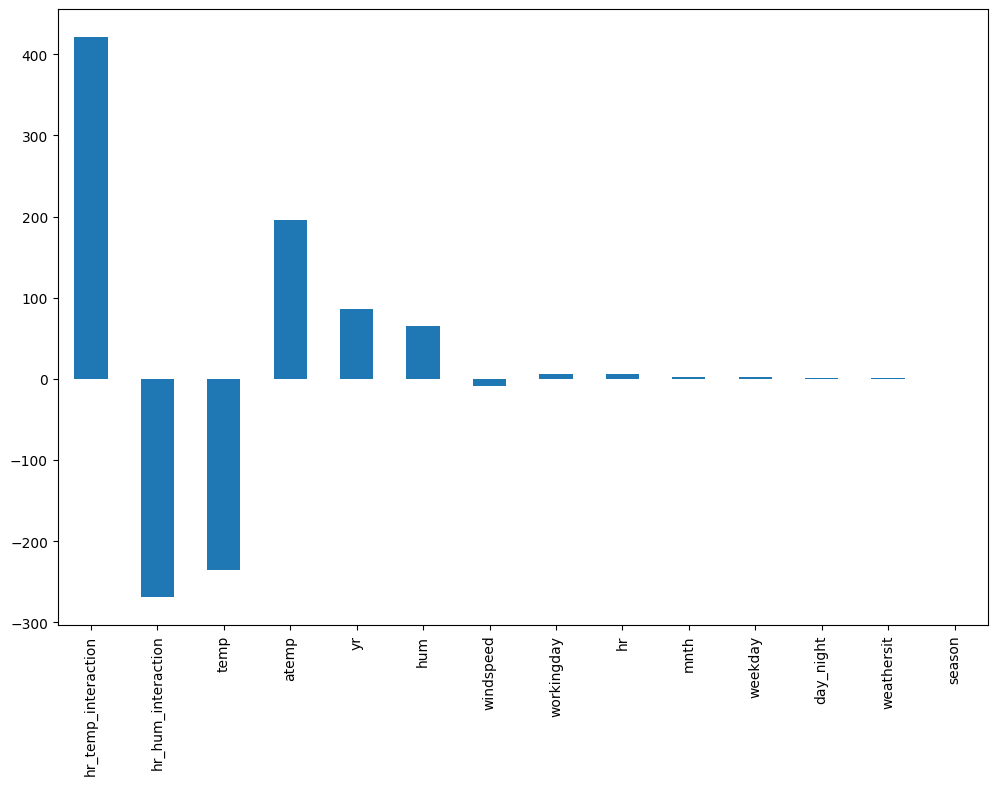

In [23]:
import matplotlib.pyplot as plt

coefficients = model.coef_
feat_importances = pd.DataFrame(coefficients, index=X_train.columns, columns=["Importance"])
feat_importances['Absolute Importance'] = feat_importances['Importance'].abs()
feat_importances.sort_values(by='Absolute Importance', ascending=False, inplace=True)
feat_importances['Importance'].plot(kind='bar', figsize=(12,8))


In [24]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 14255.542995183217
R-squared: 0.549807111497375


In [27]:
final_pipeline = Pipeline([
('num_preprocess', numerical_pipeline),
('cat_preprocess', categorical_pipeline),
('model', LinearRegression())
])

In [28]:
final_pipeline

Pipeline(steps=[('num_preprocess',
                 Pipeline(steps=[('imputer', SimpleImputer()),
                                 ('scaler', MinMaxScaler())])),
                ('cat_preprocess',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='most_frequent')),
                                 ('target_encoder',
                                  TargetEncoder(cols=[0, 1, 2]))])),
                ('model', LinearRegression())])

In [35]:
#Running this cell will use Linear Regressor that I have created from scratch

import numpy as np
def tranp(A):
  rows, cols = A.shape
  c = np.zeros((cols,rows))
  for i in range(rows):
    for j in range(cols):
      c[j][i] = A[i][j]
  return c

class Lin_Reg():
    def __init__(self):
      self.coefficient = None

    def fit(self, X, y):
      rows, cols = X.shape
      X = np.column_stack((np.ones(rows), X))
      Xtrans = tranp(X)
      ma = np.linalg.solve(np.dot(Xtrans, X), np.dot(Xtrans, y))
      self.coefficient = ma

    def pred(self, X):
      rows, cols = X.shape
      X = np.column_stack((np.ones(rows), X))
      return np.dot(X, self.coefficient)

lr = Lin_Reg()
lr.fit(X_train, y_train)


In [36]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = lr.pred(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 14255.54299518321
R-squared: 0.5498071114973753


In [38]:
final_pipeline_1 = Pipeline([
('num_preprocess', numerical_pipeline),
('cat_preprocess', categorical_pipeline),
('model', Lin_Reg())
])

In [39]:
final_pipeline_1

Pipeline(steps=[('num_preprocess',
                 Pipeline(steps=[('imputer', SimpleImputer()),
                                 ('scaler', MinMaxScaler())])),
                ('cat_preprocess',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='most_frequent')),
                                 ('target_encoder',
                                  TargetEncoder(cols=[0, 1, 2]))])),
                ('model', <__main__.Lin_Reg object at 0x7de4a2b2a0b0>)])